In [ ]:
import anndata as ad
import squidpy as sq
import cellcharter as cc
import pandas as pd
import scanpy as sc
import scvi
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from lightning.pytorch import seed_everything
import seaborn as sns
import pymde

seed_everything(12345)
scvi.settings.seed = 12345

[rank: 0] Seed set to 12345
[rank: 0] Seed set to 12345


In [ ]:
adata_list = []
for sample in ['1', '2', '3', '4', '5', '6', '7']:
    adata = sc.read_10x_h5(filename=f'/data/cephfs-2/unmirrored/projects/lipomap/Xenium_data2/reg{sample}_rang2_ne20/outs/cell_feature_matrix.h5')
    df = pd.read_csv(f'/data/cephfs-2/unmirrored/projects/lipomap/Xenium_data2/reg{sample}_rang2_ne20/outs/cells.csv.gz')
    df.set_index(adata.obs_names, inplace=True)
    adata.obs = df.copy()
    adata.obsm["spatial"] = adata.obs[["x_centroid", "y_centroid"]].copy().to_numpy()
    # adata.obsm['spatial_fov'][:, 1] = np.max(adata.obsm['spatial_fov'][:, 1]) - adata.obsm['spatial_fov'][:, 1] # Flip y axis
    # Remove negative probes
    adata = adata[:, [c for c in adata.var_names if 'NegPrb' not in c]].copy()
    adata.obs['sample'] = sample
    adata_list.append(adata)

Region7_Unsplit = adata_list[6]

Cells_R7=pd.read_csv("/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/Niche_DE_Rang20/20242309_Split_R7_Rang20/Region_7_cells_stats.csv", skiprows=2)
cellIDs_R7=Cells_R7["Cell ID"]
IDs_R7=cellIDs_R7.to_list()
Cells_R8=pd.read_csv("/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/Niche_DE_Rang20/20242309_Split_R7_Rang20/Region_8_cells_stats.csv", skiprows=2)
cellIDs_R8=Cells_R8["Cell ID"]
IDs_R8=cellIDs_R8.to_list()
Cells_R9=pd.read_csv("/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/Niche_DE_Rang20/20242309_Split_R7_Rang20/Region_9_cells_stats.csv", skiprows=2)
cellIDs_R9=Cells_R9["Cell ID"]
IDs_R9=cellIDs_R9.to_list()

Region7_Split=Region7_Unsplit[IDs_R7,:]
Region8_Split=Region7_Unsplit[IDs_R8,:]
Region8_Split.obs["sample"]="8"
Region9_Split=Region7_Unsplit[IDs_R9,:]
Region9_Split.obs["sample"]="9"

adata_list[6]=Region7_Split

adata_list.append(Region8_Split)
adata_list.append(Region9_Split)

adata = ad.concat(adata_list, axis=0, merge='same', pairwise=True, index_unique='_')

# 'spatial_fov' refers to global coordinates of the cells.
# Thus, we are going to use 'spatial_fov' and not 'spatial' as spatial coordinates.
adata.uns['spatial'] = {s: {} for s in adata.obs['sample'].unique()}
adata.obs['sample'] = pd.Categorical(adata.obs['sample'])
adata

sc.pp.filter_genes(adata, min_counts=3)
sc.pp.filter_cells(adata, min_counts=3)
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

scvi.settings.seed = 12345
scvi.model.SCVI.setup_anndata(
    adata, 
    layer="counts", 
    batch_key='sample'
)
model = scvi.model.SCVI(adata)
model.train(early_stopping=True, enable_progress_bar=True)
adata.obsm['X_scVI'] = model.get_latent_representation(adata).astype(np.float32)

SCVI_MDE_KEY = "X_scVI_MDE"
adata.obsm[SCVI_MDE_KEY] = scvi.model.utils.mde(adata.obsm['X_scVI'], accelerator="cpu")

# map RCTD Celltypes to Adata

Name_CT_All= pd.read_csv("/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/NameCT_All.csv", index_col=1)
Name_CT_All = Name_CT_All.drop("Unnamed: 0", axis=1)
Name_CT_All = Name_CT_All.rename(columns={"Ident":"cell_types"})
Name_CT_All = Name_CT_All[~Name_CT_All.index.duplicated(keep='first')]

NameCT_Dict = {Name_CT_All.index[i]:Name_CT_All.cell_types[i] for i in range(len(Name_CT_All.index))}

adata.obs['cell_types'] = adata.obs['cell_id'].map(NameCT_Dict)
adata.obs['cell_types'] = adata.obs['cell_types'].astype('category')

# Plot Embedding

sc.pl.embedding(
    adata,
    basis=SCVI_MDE_KEY,
    color=["sample", "cell_types"],
    frameon=False,
    ncols=1,
    legend_loc="center left",
    legend_fontsize='small',
)

# Get all the axes (one for each subplot) and adjust the legends
fig, axes = plt.gcf(), plt.gcf().axes  # Get current figure and axes

# Adjust legend for each subplot
for ax in axes:
    legend = ax.get_legend()
    legend.set_bbox_to_anchor((1.05, 0.5))  # Shift each legend to the right
    legend._legend_box.align = "left"       # Aligns the content of the legend if needed

# Ensure tight layout to avoid clipping
plt.tight_layout()

# Save the figure with all elements included
plt.savefig('/data/cephfs-1/home/users/rauertc_c/liposarcoma-wgs/20241104_CC_Xenium_SCVIEpoch/20241106_7Epoch/SCVI_7_Embedding.pdf', bbox_inches="tight")
plt.close()

sq.gr.spatial_neighbors(adata, library_key='sample', coord_type='generic', delaunay=True, spatial_key='spatial')
cc.gr.remove_long_links(adata)
cc.gr.aggregate_neighbors(adata, n_layers=3, use_rep='X_scVI', out_key='X_cellcharter', sample_key='sample')

autok = cc.tl.ClusterAutoK(
    n_clusters=(2,10), 
    max_runs=10,
    convergence_tol=0.001
)
autok.fit(adata, use_rep='X_cellcharter')

autok.save('/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k7_25')

/tmp/ipykernel_1615707/725293456.py:28: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Region8_Split.obs["sample"]="8"
/tmp/ipykernel_1615707/725293456.py:30: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Region9_Split.obs["sample"]="9"
[rank: 0] Seed set to 12345
/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-

Epoch 7/7: 100%|██████████| 7/7 [11:34<00:00, 99.14s/it, v_num=1, train_loss_step=149, train_loss_epoch=130] 

`Trainer.fit` stopped: `max_epochs=7` reached.


Epoch 7/7: 100%|██████████| 7/7 [11:34<00:00, 99.25s/it, v_num=1, train_loss_step=149, train_loss_epoch=130]


  0%|          | 0/9 [00:00<?, ?it/s]

Iteration 1/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 2/10


  0%|          | 0/11 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 4/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 5/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 6/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 8/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 9/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 10/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...
/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/torchgmm/base/estimator/configurable.py:23: UserWarning: Failed to serialize fitted attributes of `GaussianMixture` to JSON. Falling back to `pickle`.
  super().save_attributes(path)


In [36]:
Region7_Unsplit

AnnData object with n_obs × n_vars = 334402 × 377
    obs: 'cell_id', 'x_centroid', 'y_centroid', 'transcript_counts', 'control_probe_counts', 'control_codeword_counts', 'unassigned_codeword_counts', 'deprecated_codeword_counts', 'total_counts', 'cell_area', 'nucleus_area', 'sample'
    var: 'gene_ids', 'feature_types', 'genome'
    obsm: 'spatial'

/tmp/ipykernel_1519493/1431696759.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Region8_Split.obs["sample"]="8"
/tmp/ipykernel_1519493/1431696759.py:5: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Region9_Split.obs["sample"]="9"


[rank: 0] Seed set to 12345
/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Epoch 7/7: 100%|██████████| 7/7 [10:36<00:00, 90.76s/it, v_num=1, train_loss_step=149, train_loss_epoch=130]

`Trainer.fit` stopped: `max_epochs=7` reached.


Epoch 7/7: 100%|██████████| 7/7 [10:36<00:00, 90.95s/it, v_num=1, train_loss_step=149, train_loss_epoch=130]


  0%|          | 0/9 [00:00<?, ?it/s]

In [ ]:
#GMM = cc.tl.Cluster(
#    n_clusters=8, 
#    random_state=12345,
#    # If running on GPU
#    #trainer_params=dict(accelerator='gpu', devices=1)
#)
#gmm.fit(adata, use_rep='X_cellcharter')
#adata.obs['spatial_cluster'] = gmm.predict(adata, use_rep='X_cellcharter')

Iteration 1/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 2/10


  0%|          | 0/11 [00:00<?, ?it/s]

Iteration 3/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 4/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 5/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 6/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 7/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 8/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 9/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 10/10


  0%|          | 0/11 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


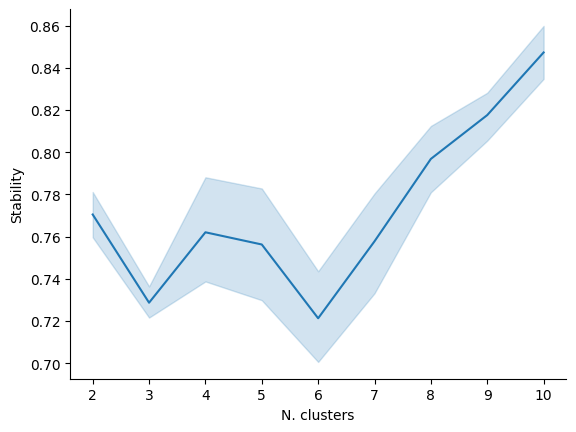

In [44]:
cc.pl.autok_stability(autok)


In [4]:
autok20 = cc.tl.ClusterAutoK(
    n_clusters=(2,20), 
    max_runs=5,
    convergence_tol=0.001
)
autok20.fit(adata, use_rep='X_cellcharter')

Iteration 1/5


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 2/5


  0%|          | 0/21 [00:00<?, ?it/s]

Iteration 3/5


  0%|          | 0/21 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 4/5


  0%|          | 0/21 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


Iteration 5/5


  0%|          | 0/21 [00:00<?, ?it/s]

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


In [55]:
autok20 = cc.tl.ClusterAutoK(
    n_clusters=(2,20), 
    max_runs=5,
    convergence_tol=0.001
)

In [5]:
autok20.save('/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20')

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/torchgmm/base/estimator/configurable.py:23: UserWarning: Failed to serialize fitted attributes of `GaussianMixture` to JSON. Falling back to `pickle`.
  super().save_attributes(path)


In [56]:
autok20.load('/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20')

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/torch/storage.py:414: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental 

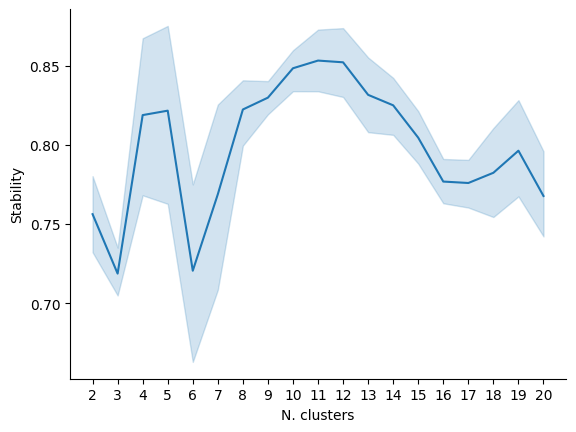

In [6]:
cc.pl.autok_stability(autok20)


In [7]:
adata.obs['cluster_cellcharter'] = autok20.predict(adata, use_rep='X_cellcharter')

/data/cephfs-1/work/groups/dubois/users/rauertc_c/miniconda/envs/genomics/envs/anndata/lib/python3.12/site-packages/lightning_fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /data/cephfs-1/work/groups/dubois/users/rauertc_c/mi ...


In [58]:
adata.obs['k5cluster_cellcharter'] = autok20.predict(adata, k=5)     palette='Set2',

AttributeError: 'ClusterAutoK' object has no attribute 'best_models'

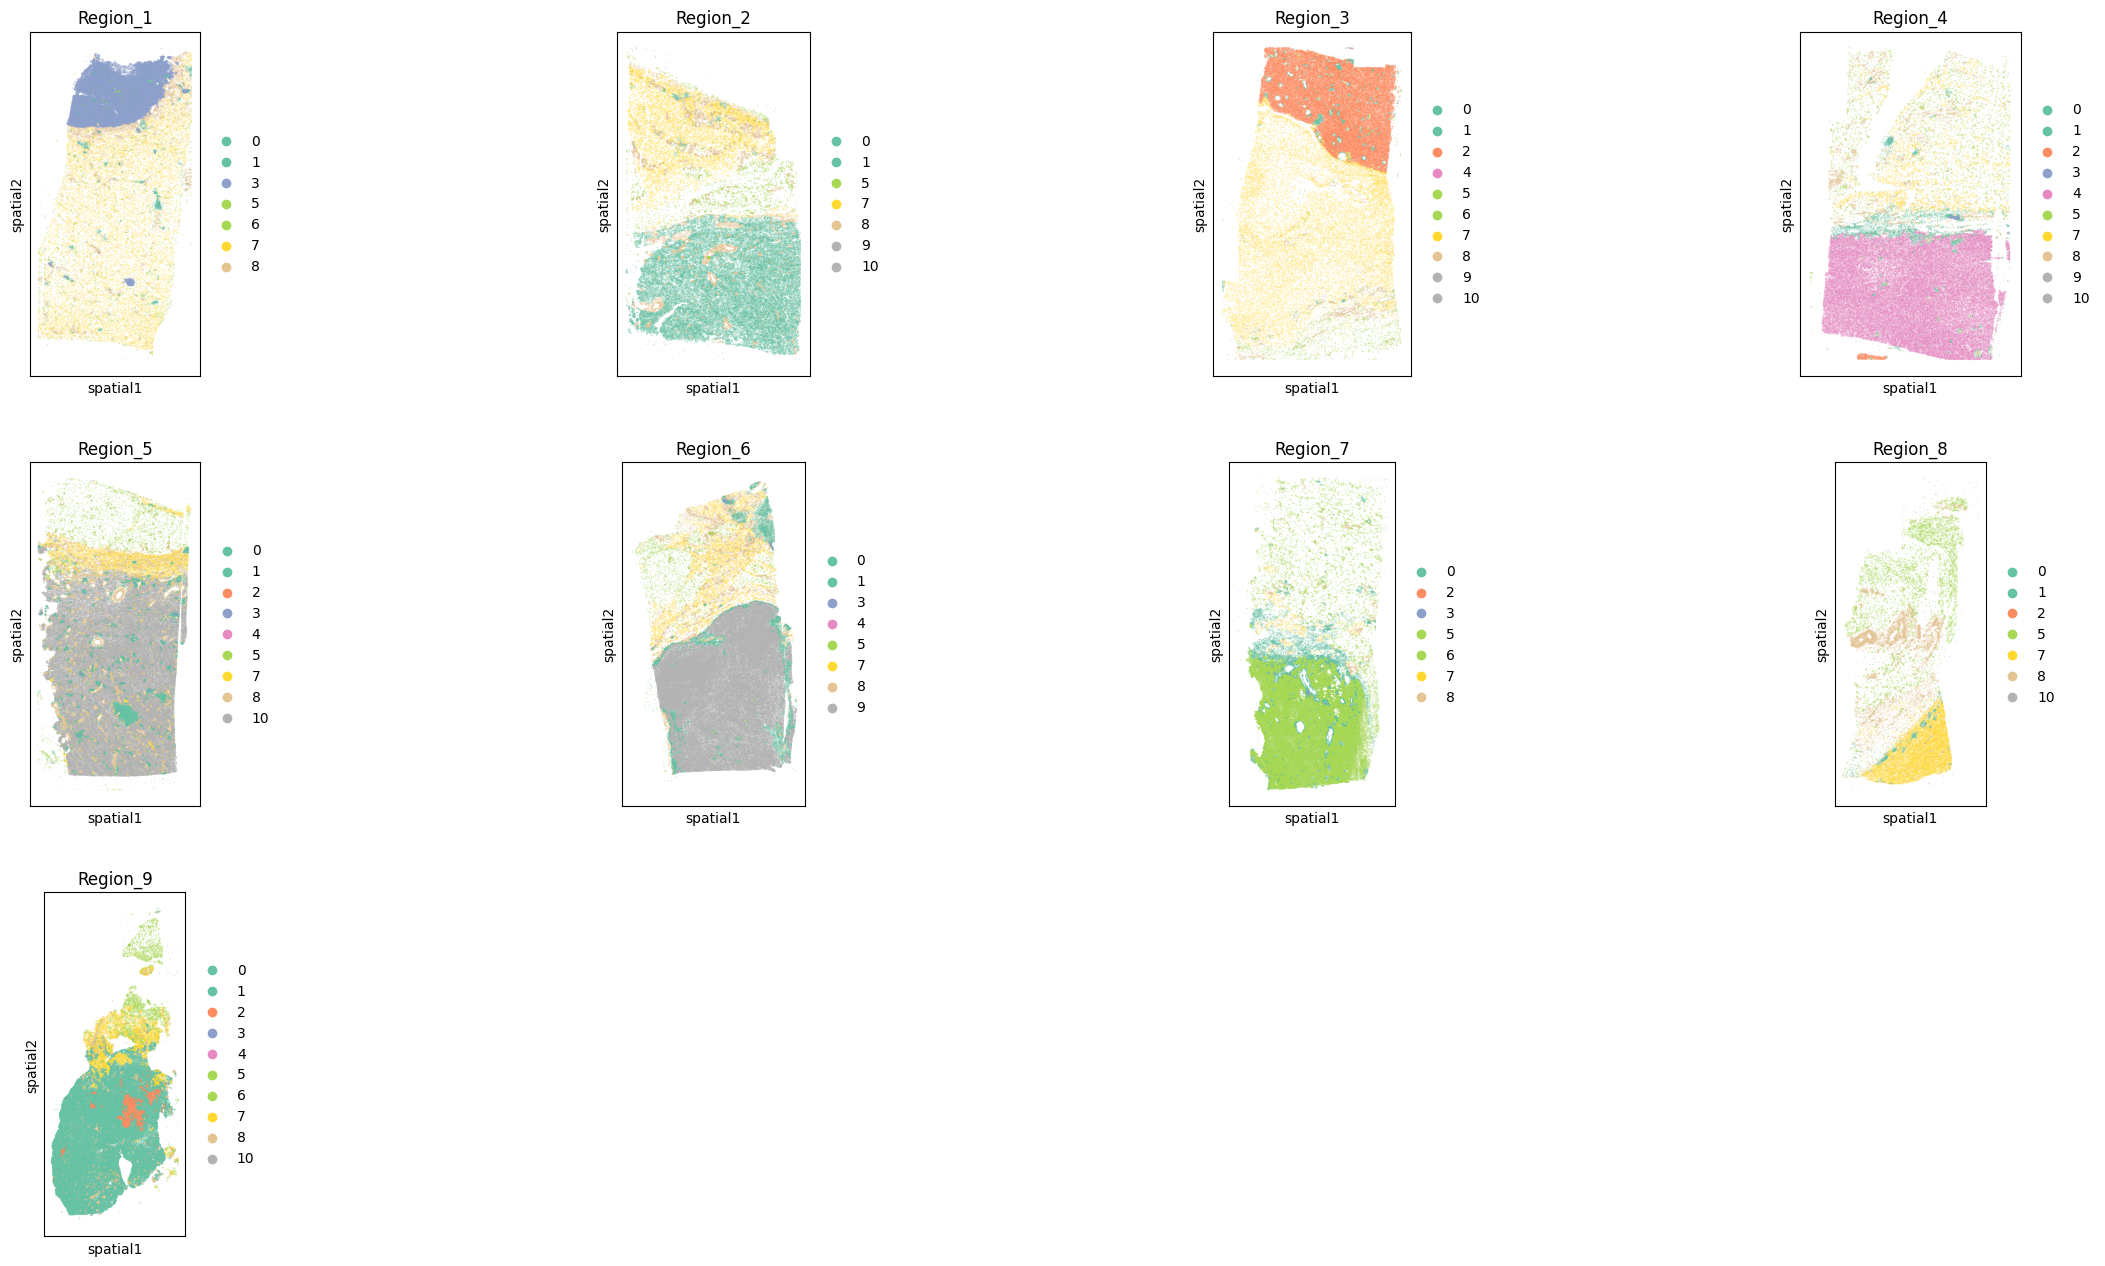

In [59]:
sq.pl.spatial_scatter(
    adata,
    color=["cluster_cellcharter"],
    img=None,
    library_key='sample',
    spatial_key="spatial",
    library_id = ['1', '2', '3', '4', '5', '6', '7', '8', '9'],
    size=10,
    ncols=4,
    title=['Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9'], 
    save=f'/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20240924_T_LS_Xenium_scatter_all_annotclsts.pdf'
)

In [27]:
cluster2region = {
    1: 'DDLS_R2R9',
    2: 'DDLS_R3',
    3: 'Immune',
    4: 'DDLS_R4',
    5: 'WDLS_R5R7R8R9',
    6: 'DDLS_R7',
    7: 'DDLS_R8',
    8: 'DDLS_R5R6',
    9: 'DDLS_R6',
    10: 'DDLS_R5',
    0: 'perivascular_tumor'
}

adata.obs['spatial_cluster'] = adata.obs['cluster_cellcharter'].map(cluster2region)
adata.obs['spatial_cluster'] = adata.obs['spatial_cluster'].astype('category')

In [28]:
adata.write('/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20240924cc_adata_LS_Xenium_k11clstrd.h5ad')

In [52]:
adata=ad.read_h5ad('/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20240924cc_adata_LS_Xenium_k11clstrd.h5ad')

In [29]:
adata.obs.to_csv('/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20240924_cc_adata_LS_Xenium_k11clstrd_adata.obs_.csv', index=False)
adata.var.to_csv('/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20240924_cc_LS_Xenium_k11clstrd_adata.var_.csv', index=True)

In [30]:
dense_Countsmatrix = adata.layers['counts'].toarray()

In [31]:
pd.DataFrame(dense_Countsmatrix).to_csv('/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20240924_cc_adata_LS_Xenium_k11clstrd_CountMat_.csv', index=False)

In [44]:
Name_CT_All=pd.read_csv("/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/NameCT_All.csv", index_col=1)
Name_CT_All = Name_CT_All.drop("Unnamed: 0", axis=1)
Name_CT_All = Name_CT_All.rename(columns={"Ident":"cell_types"})
Name_CT_All = Name_CT_All[~Name_CT_All.index.duplicated(keep='first')]

In [45]:
NameCT_Dict = {Name_CT_All.index[i]:Name_CT_All.cell_types[i] for i in range(len(Name_CT_All.index))}

/tmp/ipykernel_3006588/178308833.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  NameCT_Dict = {Name_CT_All.index[i]:Name_CT_All.cell_types[i] for i in range(len(Name_CT_All.index))}


In [49]:
adata.obs['cell_types'] = adata.obs['cell_id'].map(NameCT_Dict)
adata.obs['cell_types'] = adata.obs['cell_types'].astype('category')

In [50]:
adata.obs.head()

,cell_id,x_centroid,y_centroid,transcript_counts,control_probe_counts,control_codeword_counts,unassigned_codeword_counts,deprecated_codeword_counts,total_counts,cell_area,nucleus_area,sample,n_counts,_scvi_batch,_scvi_labels,cluster_cellcharter,spatial_cluster,cell_types
aaaabfnf-1_0,aaaabfnf-1,1159.140503,2885.981689,36,0,0,0,0,36,33.822032,21.991095,1,36.0,0,0,3,Immune,b_cell
aaaacfpk-1_0,aaaacfpk-1,1150.861084,2893.275635,66,0,0,1,0,67,92.344535,34.815470,1,66.0,0,0,3,Immune,b_cell
aaaafnmg-1_0,aaaafnmg-1,1159.354736,2893.036621,41,0,1,0,0,42,57.709690,32.060939,1,41.0,0,0,3,Immune,t_cell
aaabpmfh-1_0,aaabpmfh-1,1149.661499,2884.292969,90,0,0,0,0,90,116.728910,33.235001,1,90.0,0,0,3,Immune,t_cell
aaacdhod-1_0,aaacdhod-1,1149.526489,2876.195557,88,0,0,0,0,88,140.345630,33.505939,1,88.0,0,0,3,Immune,t_cell


In [51]:
adata.obs.to_csv('/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20240924_cc_adata_LS_Xenium_k11clstrd_adata.obs_.csv', index=False)

In [ ]:
adata=ad.read_h5ad('/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20240924cc_adata_LS_Xenium_k11clstrd.h5ad')
autok = cc.tl.ClusterAutoK.load('/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20')
adata.obs['k5cluster_cellcharter'] = autok.predict(adata, k=5)
adata.obs['k2cluster_cellcharter'] = autok.predict(adata, k=2)

cluster2region_k11 = {
    1: 'DDLS_R2R9',
    2: 'DDLS_R3R9',
    3: 'Immune',
    4: 'DDLS_R4',
    5: 'WDLS1',
    6: 'DDLS_R7',
    7: 'WDLS2',
    8: 'Vessel',
    9: 'DDLS_R6',
    10: 'DDLS_R5',
    0: 'perivascular_tumor'
}

adata.obs['spatial_cluster_k11'] = adata.obs['cluster_cellcharter'].map(cluster2region_k11)
adata.obs['spatial_cluster_k11'] = adata.obs['spatial_cluster_k11'].astype('category')

cluster_colors_11 = {"DDLS_R2R9":"#1f77b4",  # Blue
                  "DDLS_R3R9":"#ff7f0e",  # Orange
                  "Immune":"#2ca02c",  # Green
                  "DDLS_R4":"#d62728",  # Red
                  "WDLS1":"#9467bd",  # Purple
                  "DDLS_R7":"#8c564b",  # Brown
                  "WDLS2":"#e377c2",  # Pink
                  "Vessel":"#7f7f7f",  # Gray
                  "DDLS_R6":"#bcbd22",  # Yellow-green
                  "DDLS_R5":"#17becf",  # Teal
                  "perivascular_tumor":"#aec7e8"}  # Light blue

ax = sq.pl.spatial_scatter(
    adata,
    color=["spatial_cluster_k11"],
    img=None,
    #palette=custom_cmap,
    library_key='sample',
    spatial_key="spatial",
    library_id = ['1', '2', '3', '4', '5', '6', '7', '8', '9'],
    size=10,
    ncols=4,
    title=['Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9'], 
    #save=f'/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20241004_Xenium_Scatter_K11_Annot_Fix.pdf'
    return_ax=True
)

# Since `return_ax=True`, `ax` could be a list of axes if there are multiple subplots (one per library).
# Loop through each axis and update the colors
if isinstance(ax, list):  # If there are multiple axes
    for ax_i in ax:
        for collection in ax_i.collections:
            # Get the cluster label for each scatter group
            label = collection.get_label()
            # If the label corresponds to one of your clusters, change its color
            if label in cluster_colors_11:
                collection.set_color(cluster_colors_11[label])
else:
    # If there's only a single axis, handle it directly
    for collection in ax.collections:
        label = collection.get_label()
        if label in cluster_colors_11:
            collection.set_color(cluster_colors_11[label])

# Save the plot to a PDF file
plt.savefig("/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20241004_Xenium_Scatter_K11_Annot_Fix.pdf", format="pdf")

cluster2region_k5 = {
    1: 'DDLS1',
    2: 'DDLS2',
    3: 'DDLS_Low_Grade',
    4: 'Immune',
    0: 'WDLS'
}

adata.obs['spatial_cluster_k5'] = adata.obs['k5cluster_cellcharter'].map(cluster2region_k5)
adata.obs['spatial_cluster_k5'] = adata.obs['spatial_cluster_k5'].astype('category')

cluster_colors_5 = {"DDLS1":"#1f77b4",  # Blue
                  "DDLS2":"#ff7f0e",  # Orange
                  "DDLS_Low_Grade":"#2ca02c",  # Green
                  "Immune":"#d62728",  # Red
                  "WDLS":"#9467bd",}  # Purple

ax = sq.pl.spatial_scatter(
    adata,
    color=["spatial_cluster_k5"],
    img=None,
    #palette=custom_cmap,
    library_key='sample',
    spatial_key="spatial",
    library_id = ['1', '2', '3', '4', '5', '6', '7', '8', '9'],
    size=10,
    ncols=4,
    title=['Region_1', 'Region_2', 'Region_3', 'Region_4', 'Region_5', 'Region_6', 'Region_7', 'Region_8', 'Region_9'], 
    #save=f'/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20241004_Xenium_Scatter_K11_Annot_Fix.pdf'
    return_ax=True
)

# Since `return_ax=True`, `ax` could be a list of axes if there are multiple subplots (one per library).
# Loop through each axis and update the colors
if isinstance(ax, list):  # If there are multiple axes
    for ax_i in ax:
        for collection in ax_i.collections:
            # Get the cluster label for each scatter group
            label = collection.get_label()
            # If the label corresponds to one of your clusters, change its color
            if label in cluster_colors_5:
                collection.set_color(cluster_colors_5[label])
else:
    # If there's only a single axis, handle it directly
    for collection in ax.collections:
        label = collection.get_label()
        if label in cluster_colors_5:
            collection.set_color(cluster_colors_5[label])

# Save the plot to a PDF file
plt.savefig("/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20241004_Xenium_Scatter_K5_Annot_Fix.pdf", format="pdf")

# make subtype map from k11

region2subtype_k11 = {
    'DDLS_R2R9':'DDLS',
    'DDLS_R3R9':'DDLS',
    'Immune':'Immune/Healthy',
    'DDLS_R4':'DDLS',
    'WDLS1':'WDLS',
    'DDLS_R7':'DDLS',
    'WDLS2':'WDLS',
    'Vessel':'Immune/Healthy',
    'DDLS_R6':'DDLS',
    'DDLS_R5':'DDLS',
    'perivascular_tumor':'perivascular_tumor'
}

adata.obs['subtype'] = adata.obs['spatial_cluster_k11'].map(region2subtype_k11)
adata.obs['subtype'] = adata.obs['subtype'].astype('category')

# map RCTD Celltypes to Adata

Name_CT_All= pd.read_csv("/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/NameCT_All.csv", index_col=1)
Name_CT_All = Name_CT_All.drop("Unnamed: 0", axis=1)
Name_CT_All = Name_CT_All.rename(columns={"Ident":"cell_types"})
Name_CT_All = Name_CT_All[~Name_CT_All.index.duplicated(keep='first')]

NameCT_Dict = {Name_CT_All.index[i]:Name_CT_All.cell_types[i] for i in range(len(Name_CT_All.index))}

adata.obs['cell_types'] = adata.obs['cell_id'].map(NameCT_Dict)
adata.obs['cell_types'] = adata.obs['cell_types'].astype('category')

adata.obs.head()

# Save Files for R

adata.obs.to_csv('/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20240924_cc_adata_LS_Xenium_k11k5clstrd_adata.obs_.csv', index=False)
adata.var.to_csv('/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20240924_cc_LS_Xenium_k11k5clstrd_adata.var_.csv', index=True)

dense_Countsmatrix = adata.layers['counts'].toarray()
pd.DataFrame(dense_Countsmatrix).to_csv('/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20240924_cc_adata_LS_Xenium_k11k5clstrd_CountMat_.csv', index=False)

adata.write('/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20240924cc_adata_LS_Xenium_k11k5clstrd.h5ad')

In [ ]:
adata=ad.read_h5ad('/data/cephfs-2/unmirrored/projects/liposarcoma-wgs/20240923cellcharterXenium_auto_k2_k20/20240924cc_adata_LS_Xenium_k11clstrd.h5ad')
